In [1]:
from math import e, factorial,log, gamma, sqrt, floor
from matplotlib import pyplot as pt
from numpy.random import geometric,exponential,poisson
from scipy.stats import ks_2samp
from scipy.stats import norm
from numpy import linspace
from IPython.display import Markdown
from analysis import *

# Load data

In [2]:
f1 = open("r1-d0-result.txt")
raw1 = f1.read()
f1.close()

f2 = open("r1-d1-result.txt")
raw2 = f2.read()
f2.close()

f3 = open("r5-d0-result.txt")
raw3 = f3.read()
f3.close()

f4 = open("r5-d1-result.txt")
raw4 = f4.read()
f4.close()

f5 = open("r9-d0-result.txt")
raw5 = f5.read()
f5.close()

f6 = open("r9-d1-result.txt")
raw6 = f6.read()
f6.close()

f7 = open("r7-d0-result.txt")
raw7 = f7.read()
f7.close()

f8 = open("r7-d1-result.txt")
raw8 = f8.read()
f8.close()

In [3]:
Ttx = 1
Trx = 10
Tn = 1
    
def compute_histogram(r1,r2):

    Eb,Es,En = computeEvents(r1,Ttx,Trx,Tn)

    display(Markdown('<span style="color: #af0000">'+"P(S) = %.6f"%(Trx*Es/len(r1))+'</span>'))
    display(Markdown('<span style="color: #00af00">'+"P(N) = %.6f"%(Tn*En/len(r1))+'</span>'))
    display(Markdown('<span style="color: #0000af">'+"P(B) = %.6f"%(Ttx*Eb/len(r1))+'</span>'))

    l1 = 1000*Eb / (len(r1))

    rt = Trx*Eb/len(r1)

    print("r(B)(Events/s) = %.6f"%(l1))
    print("rt = %.6f"%(rt))

    scan_intervals = findScanInterval(r2,r1,Ttx,Trx)

    hist1 = generateHistogram(scan_intervals,Trx)
    print("Success probability evts: %.6f"%(checkSuccess(r2,r1)[0]/Eb))
    print("Success probability= %.6f"%sum(hist1[1:]))
    return hist1,rt,Eb,Es,En

In [4]:
def checkPoisson(r1,r2, wnd, start):
    count = 0
    for i in range(start,start+wnd+1):
        if r1[i]=='S' and r2[i]=='B':
            count += 1
    return count

def genWindowHistogram(r1,r2,wnd,Eb):
    windows = {}
    for i in range(0,len(r1),wnd):
        count = 0
        for j in range(i,i+wnd):
            if r1[i]=='S' and r2[i]=='B':
                count += 1
        try:
            windows[count]+=1
        except:
            windows[count] = 1
    for k in windows:
        windows[k] /= Eb
    return windows

<span style="color: #af0000">P(S) = 0.526647</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.473353</span>

r(B)(Events/s) = 473.352600
rt = 4.733526
Success probability evts: 0.527606
Success probability= 0.900138
---------------------


<span style="color: #af0000">P(S) = 0.909124</span>

<span style="color: #00af00">P(N) = 0.000001</span>

<span style="color: #0000af">P(B) = 0.090875</span>

r(B)(Events/s) = 90.874800
rt = 0.908748
Success probability evts: 0.910498
Success probability= 0.499783
---------------------


<span style="color: #af0000">P(S) = 0.989007</span>

<span style="color: #00af00">P(N) = 0.000001</span>

<span style="color: #0000af">P(B) = 0.010992</span>

r(B)(Events/s) = 10.991800
rt = 0.109918
Success probability evts: 0.986226
Success probability= 0.099815
---------------------


<span style="color: #af0000">P(S) = 0.958889</span>

<span style="color: #00af00">P(N) = 0.000001</span>

<span style="color: #0000af">P(B) = 0.041110</span>

r(B)(Events/s) = 41.109700
rt = 0.411097
Success probability evts: 0.959958
Success probability= 0.300450
---------------------


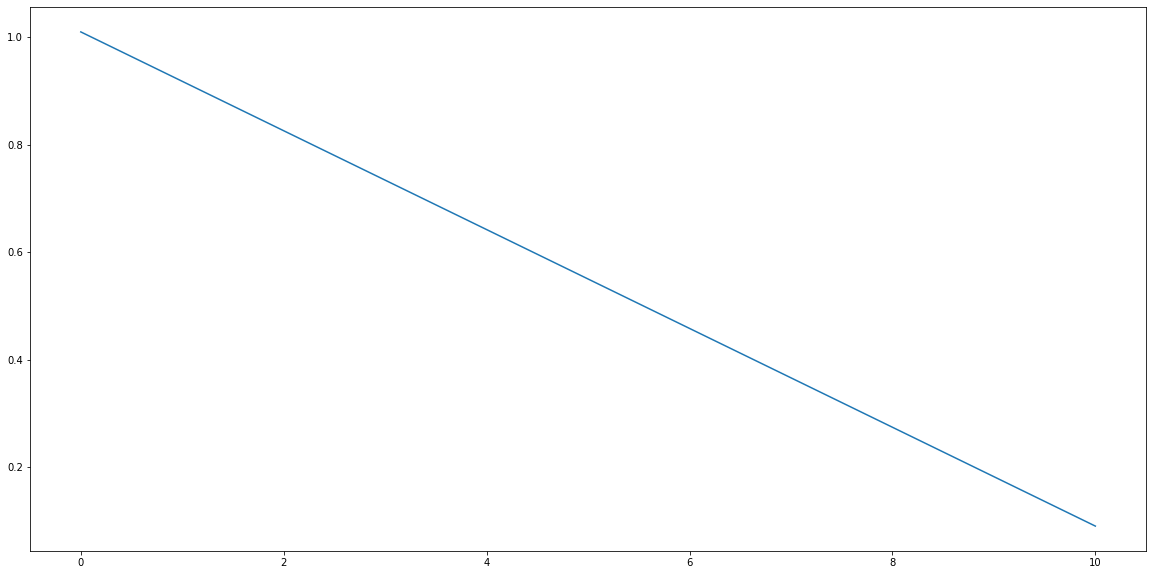

In [8]:
hist1,rt1,Eb1,Es1,En1 = compute_histogram(raw1,raw2)
print('---------------------')
hist2,rt2,Eb2,Es2,En2 = compute_histogram(raw3,raw4)
print('---------------------')
hist3,rt3,Eb3,Es3,En3 = compute_histogram(raw5,raw6)
print('---------------------')
hist4,rt4,Eb4,Es4,En4 = compute_histogram(raw7,raw8)
print('---------------------')
wnds = genWindowHistogram(raw3,raw4,10,Eb2)

geom_d1 = geom_dist(hist1[0],len(hist1))
geom_d2 = geom_dist(hist2[0],len(hist2))
geom_d3 = geom_dist(hist3[0],len(hist3))
geom_d4 = geom_dist(hist4[0],len(hist4))

v1 = sorted(wnds.keys())
v2 = [wnds[k] for k in v1]
pt.plot(v1,v2)
pt.show()


In [6]:
def check_distribution(hist,rt):
    rvd = poisson_dist(rt,len(hist1))
    print("RMSE Poisson= %.6f"%rmse(rvd,hist)) 
    geom_d = geom_dist(hist[0],len(hist))
    print(hist[0])
    print("RMSE Geom= %.6f"%rmse(geom_d,hist))
    
check_distribution(hist1, rt1)
print('---------------------')
check_distribution(hist2, rt2)
print('---------------------')
check_distribution(hist3, rt3)
print('---------------------')
check_distribution(hist4, rt4)

RMSE Poisson= 0.082699
0.09986214648929262
RMSE Geom= 0.049283
---------------------
RMSE Poisson= 0.043022
0.5002166921124072
RMSE Geom= 0.007331
---------------------
RMSE Poisson= 0.002764
0.9001847307450807
RMSE Geom= 0.000395
---------------------
RMSE Poisson= 0.019750
0.6995502086268588
RMSE Geom= 0.003081


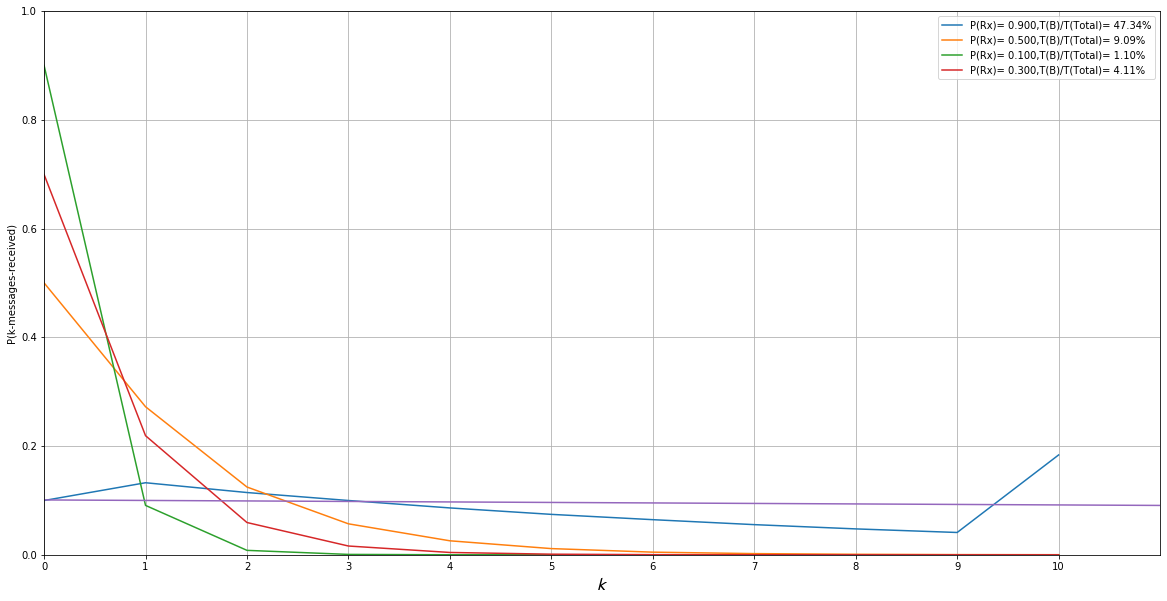

In [7]:
pt.rcParams["figure.figsize"] = (20,10)
pt.plot(range(len(hist1)),hist1,label="P(Rx)= %.3f,T(B)/T(Total)= %.2f%%"%(sum(hist1[1:]),100*Ttx*Eb1/len(raw1)))
pt.plot(range(len(hist2)),hist2,label="P(Rx)= %.3f,T(B)/T(Total)= %.2f%%"%(sum(hist2[1:]),100*Ttx*Eb2/len(raw2)))
pt.plot(range(len(hist3)),hist3,label="P(Rx)= %.3f,T(B)/T(Total)= %.2f%%"%(sum(hist3[1:]),100*Ttx*Eb3/len(raw3)))
pt.plot(range(len(hist4)),hist4,label="P(Rx)= %.3f,T(B)/T(Total)= %.2f%%"%(sum(hist4[1:]),100*Ttx*Eb4/len(raw4)))
pt.plot(v1,v2)
pt.legend()
pt.axis([0,len(hist1),0,1])
pt.xticks(range(len(hist1)), [str(n) for n in range(len(hist1))])
pt.xlabel(r'$\mathcal{k}$', fontsize = 18)
pt.ylabel(r'P(k-messages-received)')
pt.grid(True)
pt.show()